# Library Import

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Load Dataset

In [2]:
df = pd.read_csv("AirQuality_ModelReady.csv", index_col="timestamp", parse_dates=True)

# Preparation

In [3]:
pollutants = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
horizons = [1, 6, 12, 24]
lags = [1, 2, 3, 24]

# CO Discretization

In [4]:
CO_class_le = LabelEncoder()
CO_class_le.fit(["low", "mid", "high"])

def get_CO_class(CO_val):
    if CO_val < 1.5:
        return "low"
    elif CO_val < 2.5:
        return "mid"
    else:
        return "high"

def get_CO_classes(CO_vals, prefix):
    CO_class = CO_vals.apply(get_CO_class)
    CO_class_l_encoded = CO_class_le.transform(CO_class)
    CO_class_oh_encoded = pd.get_dummies(
        pd.Series(CO_class),
        prefix = prefix,
        dtype = int,
        drop_first = False
    )
    CO_classes = pd.DataFrame({
        prefix + "_class": CO_class,
        prefix + "_class_l_encoded": CO_class_l_encoded
    })

    return pd.concat([CO_classes, CO_class_oh_encoded], axis = 1)

df_temp = df.copy()
CO_classes = get_CO_classes(df_temp["CO"], "CO")
df_temp = pd.concat([df_temp, CO_classes], axis = 1)

for h in horizons:
    df_temp[f"CO_fut_{h}h"] = df_temp[f"CO_fut_{h}h"].fillna(df_temp[f"CO_fut_{h}h"].mean())
    CO_fut_h_classes = get_CO_classes(df_temp[f"CO_fut_{h}h"], f"CO_fut_{h}h")
    df_temp = pd.concat([df_temp, CO_fut_h_classes], axis = 1)

pd.set_option('display.max_columns', None)
df_temp.head(5)

,Date,Time,CO,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,weekday,month,CO_lag_1,CO_lag_3,CO_lag_12,CO_lag_24,CO_roll_mean_3,CO_roll_mean_6,CO_roll_mean_12,CO_roll_mean_24,CO_fut_1h,CO_fut_6h,CO_fut_12h,CO_fut_24h,hour_scaled,weekday_scaled,month_scaled,T_scaled,RH_scaled,AH_scaled,PT08.S1(CO)_scaled,PT08.S2(NMHC)_scaled,PT08.S3(NOx)_scaled,PT08.S4(NO2)_scaled,PT08.S5(O3)_scaled,CO_lag_1_scaled,CO_lag_12_scaled,CO_lag_24_scaled,CO_roll_mean_3_scaled,CO_roll_mean_6_scaled,CO_roll_mean_12_scaled,CO_roll_mean_24_scaled,CO_class,CO_class_l_encoded,CO_high,CO_low,CO_mid,CO_fut_1h_class,CO_fut_1h_class_l_encoded,CO_fut_1h_high,CO_fut_1h_low,CO_fut_1h_mid,CO_fut_6h_class,CO_fut_6h_class_l_encoded,CO_fut_6h_high,CO_fut_6h_low,CO_fut_6h_mid,CO_fut_12h_class,CO_fut_12h_class_l_encoded,CO_fut_12h_high,CO_fut_12h_low,CO_fut_12h_mid,CO_fut_24h_class,CO_fut_24h_class_l_encoded,CO_fut_24h_high,CO_fut_24h_low,CO_fut_24h_mid
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,2.0,3.0,1.8,NaN,1.8,1.8,1.866667,1.933333,1.991667,2.126087,2.0,1.200000,0.7,4.8,0.939133,-0.504915,-0.962879,-0.542585,-0.020532,-0.673353,1.228781,0.412925,0.880318,0.693887,0.633214,-0.218646,-0.218236,-0.218715,-0.177847,-0.156524,-0.146915,-0.032808,high,0,1,0,0,mid,2,0,0,1,low,1,0,1,0,low,1,0,1,0,high,0,1,0,0
2004-03-10 19:00:00,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19.0,2.0,3.0,2.6,NaN,1.8,1.8,2.600000,2.600000,2.600000,2.600000,2.2,1.000000,1.1,6.9,1.083583,-0.504915,-0.962879,-0.577236,-0.091228,-0.754948,0.909382,0.065082,1.348952,0.301964,-0.124277,0.386060,-0.218236,-0.218715,0.415700,0.449729,0.510286,0.571119,mid,2,0,0,1,mid,2,0,0,1,low,1,0,1,0,low,1,0,1,0,high,0,1,0,0
2004-03-10 20:00:00,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,2.0,3.0,2.0,NaN,1.8,1.8,2.300000,2.300000,2.300000,2.300000,2.2,0.900000,2.0,6.1,1.228033,-0.504915,-0.962879,-0.738941,0.279927,-0.692552,1.426057,0.003922,1.213922,0.290176,0.136750,-0.067470,-0.218236,-0.218715,0.172885,0.176915,0.186187,0.188816,mid,2,0,0,1,mid,2,0,0,1,low,1,0,1,0,mid,2,0,0,1,high,0,1,0,0
2004-03-10 21:00:00,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,2.0,3.0,2.2,2.6,1.8,1.8,2.266667,2.266667,2.266667,2.266667,1.6,0.600000,2.2,3.9,1.372483,-0.504915,-0.962879,-0.842894,0.633408,-0.600347,1.303934,0.038324,1.023291,0.375633,0.466873,0.083707,-0.218236,-0.218715,0.145906,0.146603,0.150176,0.146338,mid,2,0,0,1,mid,2,0,0,1,low,1,0,1,0,mid,2,0,0,1,high,0,1,0,0
2004-03-10 22:00:00,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,2.0,3.0,2.2,2.0,1.8,1.8,2.133333,2.250000,2.250000,2.250000,1.2,2.152895,1.7,1.5,1.516933,-0.504915,-0.962879,-0.819793,0.609842,-0.595042,0.815441,-0.389791,1.472068,0.098635,0.228878,0.083707,-0.218236,-0.218715,0.037988,0.131446,0.132170,0.125099,mid,2,0,0,1,low,1,0,1,0,mid,2,0,0,1,mid,2,0,0,1,mid,2,0,0,1


# Data Splitting

In [5]:
train = df_temp[df_temp.index.year == 2004]
test = df_temp[df_temp.index.year == 2005]

predictors = [
    "PT08.S1(CO)",
    "PT08.S2(NMHC)",
    "PT08.S3(NOx)",
    "PT08.S4(NO2)",
    "PT08.S5(O3)",
    "T",
    "RH",
    "AH",
    "hour",
    "weekday",
    "month",
    "CO_lag_1",
#    "CO_lag_3",
    "CO_lag_12",
    "CO_lag_24",
    "CO_roll_mean_3",
    "CO_roll_mean_6",
    "CO_roll_mean_12",
    "CO_roll_mean_24"
]

scaled_predictors = []

for predictor in predictors:
    scaled_predictors.append(predictor + "_scaled")

# Classification

In [6]:
random_state = 23

def predict_CO_class_using_decision_tree(params, train_df, test_df, h):
    classifier = DecisionTreeClassifier(
        max_depth = params["max_depth"],
        min_samples_leaf = params["min_samples_leaf"],
        max_features = params["max_features"],
        random_state = random_state
    )
    classifier.fit(train_df[scaled_predictors], train_df[f"CO_fut_{h}h_class_l_encoded"])
    return classifier.predict(test_df[scaled_predictors])

def predict_CO_class_using_support_vector_machine(params, train_df, test_df, h):
    classifier = SVC(
        kernel = "rbf",
        C = params["C"],
        gamma = params["gamma"],
        random_state = random_state
    )
    classifier.fit(train_df[scaled_predictors], train_df[f"CO_fut_{h}h_class_l_encoded"])
    return classifier.predict(test_df[scaled_predictors])

def predict_CO_class_using_logistic_regression(params, train_df, test_df, h):
    low_classifier = LogisticRegression(
        penalty = "l2",
        C = params["C"],
        solver = "lbfgs",
        max_iter = 1000,
        random_state = random_state
    )
    low_classifier.fit(train_df[scaled_predictors], train_df[f"CO_fut_{h}h_low"])

    mid_classifier = LogisticRegression(
        penalty = "l2",
        C = params["C"],
        solver = "lbfgs",
        max_iter = 1000,
        random_state = random_state
    )
    mid_classifier.fit(train_df[scaled_predictors], train_df[f"CO_fut_{h}h_mid"])

    high_classifier = LogisticRegression(
        penalty = "l2",
        C = params["C"],
        solver = "lbfgs",
        max_iter = 1000,
        random_state = random_state
    )
    high_classifier.fit(train_df[scaled_predictors], train_df[f"CO_fut_{h}h_high"])

    prob_matrix = np.zeros((len(test_df), 3))
    CO_class_l_encoded = CO_class_le.transform(["low", "mid", "high"])
    prob_matrix[:, CO_class_l_encoded[0]] = low_classifier.predict_proba(test_df[scaled_predictors])[:, 1]
    prob_matrix[:, CO_class_l_encoded[1]] = mid_classifier.predict_proba(test_df[scaled_predictors])[:, 1]
    prob_matrix[:, CO_class_l_encoded[2]] = high_classifier.predict_proba(test_df[scaled_predictors])[:, 1]

    return np.argmax(prob_matrix, axis = 1)

def predict_CO_class_using_naive_baseline(params, train_df, test_df, h):
    return test_df["CO_class_l_encoded"]

predictor_by_clf_name = {
    "Decision Tree": predict_CO_class_using_decision_tree,
    "Support Vector Machine": predict_CO_class_using_support_vector_machine,
    "Logistic Regression": predict_CO_class_using_logistic_regression,
    "Naive Baseline": predict_CO_class_using_naive_baseline
}

params_grids_by_clf_name = {
    "Decision Tree": {
        "max_depth": [1, 3, 5, 7, 9, 11, 13, 15, None],
        "min_samples_leaf": [1, 5, 10, 15, 20, 25],
        "max_features": [None, "sqrt", "log2"],
    },
    "Support Vector Machine": {
        "C": [0.1, 1, 10, 100, 1000],
        "gamma": ["scale", 0.1, 0.01, 0.001, 0.0001],
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100, 1000]
    },
    "Naive Baseline": {}
    
}

results = pd.DataFrame({
    "Horizon": horizons,
    "Decision Tree accuracy": [0] * len(horizons),
    "Support Vector Machine accuracy": [0] * len(horizons),
    "Logistic Regression accuracy": [0] * len(horizons),
    "Naive Baseline accuracy": [0] * len(horizons)
})

for h in horizons:
    tuning_train_ratio = 0.8
    tuning_train_test_split = int(len(train) * tuning_train_ratio)
    train_train = train.iloc[:tuning_train_test_split]
    train_test = train.iloc[tuning_train_test_split:]
    y_train_test = train_test[f"CO_fut_{h}h_class_l_encoded"]

    eff_test = test.iloc[:(-1 * h)]
    y_test = eff_test[f"CO_fut_{h}h_class_l_encoded"]

    for clf_name, predict_CO_class in predictor_by_clf_name.items():
        # Hyperparameters tuning
        params_grids = params_grids_by_clf_name[clf_name]
        param_keys = list(params_grids.keys())
        if len(param_keys) > 0:
            params_list = [params_grids[param_keys[0]]]
        else:
            param_list = []
        for i in range(1, len(param_keys)):
            result = []
            next_list = params_grids[param_keys[i]]
            for i in range(0, len(params_list)):
                for j in range(0, len(next_list)):
                    if type(params_list[i]) != list:         
                        params_list[i] = [params_list[i]]
                    temp = [num for num in params_list[i]]
                    temp.append(next_list[j])
                    result.append(temp)
            params_list = result
        params_list = [dict(zip(param_keys, row_list)) for row_list in params_list]
        
        best_params = None
        best_tuning_acc = -np.inf

        print(f"Tuning hyperparameters of {clf_name} for horizon {h}...")
        for curr_params in params_list:
            print("curr_params:", curr_params)
            y_pred_train_test = predict_CO_class(curr_params, train_train, train_test, h)
            curr_tuning_acc = accuracy_score(y_train_test,y_pred_train_test)
            print(clf_name, "with params:", curr_params, f"=> accuracy = {curr_tuning_acc:.4f}")

            if curr_tuning_acc > best_tuning_acc:
                best_tuning_acc = curr_tuning_acc
                best_params = curr_params

        print(f"For horizon: {h}, best params on validation:", best_params, f"with accuracy: {best_tuning_acc:.4f}")
        
        # Train and test the model with the tuned hyperparameters
        print(f"{clf_name} model training for horizon: {h}...")
        y_pred_test = predict_CO_class(best_params, train, eff_test, h)
        test_acc = accuracy_score(y_test, y_pred_test)
        
        print(f"Finished using {clf_name} model for horizon: {h}! Accuracy: {test_acc:.4f}\n\n")

        results.loc[results["Horizon"] == h, clf_name + " accuracy"] = test_acc
        
results

Tuning hyperparameters of Decision Tree for horizon 1...
curr_params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5}
Decision Tree with params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5} => accuracy = 0.5668
curr_params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5}
Decision Tree with params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5} => accuracy = 0.5668
curr_params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5}
Decision Tree with params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5} => accuracy = 0.5668
curr_params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5}
Decision Tree with params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5} => accuracy = 0.5668
curr_params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5}
Decision Tree with params: {'max_depth': 1, 'min_samples_leaf': 3, 'max_features': 5} => accuracy = 0.5668
curr_params: {'max_depth': 1, 'min_samples_leaf'

/tmp/ipykernel_57891/1937437457.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.46170970614425644' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[results["Horizon"] == h, clf_name + " accuracy"] = test_acc


Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3270
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3270
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3270
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3270
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3270
For horizon: 1, best params on validation: {'C': 0.1, 'gamma': 1} with accuracy: 0.3270
Support Vector Machine model training for horizon: 1...
Finished using Support Vector Machine model for horizon: 1! Accuracy: 0.3139


Tuning hyperparameters of Logistic Regression for horizon 1...
curr_params: {'C': 0.01}
Logistic Regression with params: {'C': 0.01} => accuracy = 0.5844
For horizon: 1, best params on validation: {'C': 0.01} with accuracy: 0.5844
Lo

/tmp/ipykernel_57891/1937437457.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3138913624220837' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[results["Horizon"] == h, clf_name + " accuracy"] = test_acc
/tmp/ipykernel_57891/1937437457.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5650044523597507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[results["Horizon"] == h, clf_name + " accuracy"] = test_acc
/tmp/ipykernel_57891/1937437457.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7039180765805877' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[results["H

Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3284
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3284
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3284
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3284
curr_params: {'C': 0.1, 'gamma': 1}
Support Vector Machine with params: {'C': 0.1, 'gamma': 1} => accuracy = 0.3284
For horizon: 6, best params on validation: {'C': 0.1, 'gamma': 1} with accuracy: 0.3284
Support Vector Machine model training for horizon: 6...
Finished using Support Vector Machine model for horizon: 6! Accuracy: 0.3137


Tuning hyperparameters of Logistic Regression for horizon 6...
curr_params: {'C': 0.01}
Logistic Regression with params: {'C': 0.01} => accuracy = 0.4205
For horizon: 6, best params on validation: {'C': 0.01} with accuracy: 0.4205
Lo

,Horizon,Decision Tree accuracy,Support Vector Machine accuracy,Logistic Regression accuracy,Naive Baseline accuracy
0,1,0.461710,0.313891,0.565004,0.703918
1,6,0.391789,0.313699,0.473003,0.368139
2,12,0.350783,0.313647,0.472931,0.360626
3,24,0.419703,0.311741,0.484930,0.552857


# Accuracy Plot

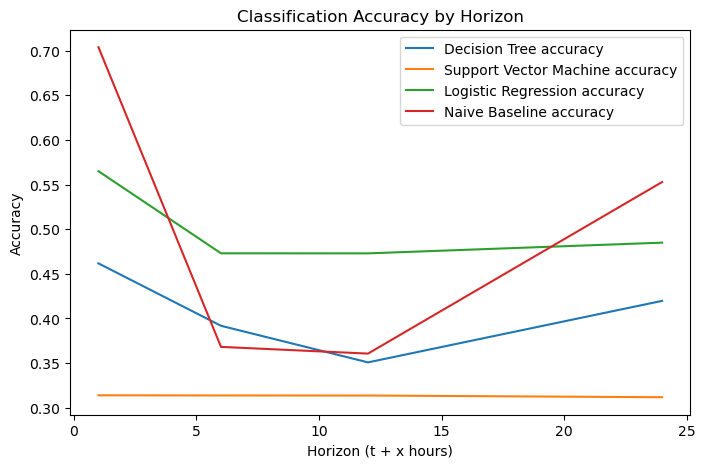

In [7]:
ax = results.plot(kind = "line", x = "Horizon", figsize=(8, 5))
ax.set_xlabel('Horizon (t + x hours)')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy by Horizon')
plt.savefig("classification-accuracy.png")
plt.show()
plt.close()

# Export Report

In [8]:
print("\n=== Exporting Data ===")

# Export to CSV
try:
    csv_filename = "co_class_results.csv"
    results.to_csv(csv_filename, index = False)
    print(f"Successfully saved results to '{csv_filename}'")
except Exception as e:
    print(f"Error saving CSV: {e}")

# Export to Excel
try:
    xlsx_filename = "co_class_results.xlsx"
    results.to_excel(xlsx_filename, index = False)
    print(f"Successfully saved results to '{xlsx_filename}'")
except ImportError:
    print(f"Could not save to Excel ({xlsx_filename}). Missing dependency.\nPlease run: pip install openpyxl")
except Exception as e:
    print(f"Error saving Excel: {e}")


=== Exporting Data ===
Successfully saved results to 'co_class_results.csv'
Successfully saved results to 'co_class_results.xlsx'
